In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import argparse
class Args:
    def __init__(self):
        pass
args = Args()

In [2]:
args.backbone="segformer"
args.base_aug_spice=0.6
args.batch_size=8
args.conf_pen=0.001
args.cross_attention_type="lite"
args.decoder="none"
args.dropout=0.6
args.ffn_dim=1024
args.frozen_backbone=False
args.fusion="early"
args.gpus="0"
args.image_size=512
args.last_n=1
args.load_checkpoint=False
args.log_file="3.log"
args.loss_fn="f1"
args.lr=0.00003
args.normalize_image=False
args.note=""
args.num_decoder_layers=3
args.num_epochs=800
args.num_workers=70
args.parallel_bca=0
args.print_every=2,000
args.resume=False
args.save_path="53615666.pth"
args.show_sample=False
args.use_bsvunet2_style_dataaug=True
args.use_tqdm=False
args.use_train_as_val=False
args.val_size=2048
args.weight_decay=0.01

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2
import torchvision.transforms.functional

import numpy as np
import cv2
import os
import cv2 as cv
import matplotlib.pyplot as plt
import random

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, mode="train"):
        self.mode = mode
        self.datapath = "/home/wg25r/fastdata/CDNet"
       
        if mode == "train":
            with open(f"{self.datapath}/train.txt") as f:
                self.images = f.read().split("\n")
        else: 
            with open(f"{self.datapath}/val.txt") as f:
                self.images = f.read().split("\n")
            self.images = random.sample(self.images, 128)


        self.ignore_after = 40 
        self.space_trans = torchvision.transforms.v2.Compose([
            torchvision.transforms.v2.RandomResizedCrop(448, scale=(0.6, 3)), 
            torchvision.transforms.v2.RandomHorizontalFlip(0.5),
            torchvision.transforms.v2.RandomRotation(20), 
            torchvision.transforms.v2.RandomApply(
                [torchvision.transforms.v2.ElasticTransform(alpha=50)], p=0.2
            ),
            torchvision.transforms.v2.RandomApply(
                [torchvision.transforms.v2.RandomPerspective()], p=0.2
            ),
            torchvision.transforms.v2.RandomApply(
                [torchvision.transforms.v2.RandomAffine(20,  scale=(0.5, 1.1))], p=0.2
            ),
        ])
        self.color_trans = torchvision.transforms.v2.Compose([
            torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.4)
        ])

    def __len__(self): 
        if self.mode == "train":
            return int(len(self.images)) 
        else: 
            return int(len(self.images))
        

    def __getitem__(self, idx):  
        filename = self.images[idx]

        current_frame = cv2.resize(cv2.imread(f"{self.datapath}/in/{filename}"), (448, 448))
        long_bg = cv2.resize(cv2.imread(f"{self.datapath}/long/{filename}"), (448, 448))
        short_bg = cv2.resize(cv2.imread(f"{self.datapath}/short/{filename}"), (448, 448)) 
        label_ = cv2.imread(f"{self.datapath}/gt/{filename}")
        label = (label_ == 255) * 255.0
        ROI =  (label_ != 85) * 255.0
        label = cv2.resize(label, (448, 448))
        ROI = cv2.resize(ROI, (448//4, 448//4)).mean(-1) > 0
        ROI = torch.tensor(ROI).float()

        current_frame = torch.tensor(current_frame).permute(2,0,1)
        long_bg = torch.tensor(long_bg).permute(2,0,1)
        short_bg = torch.tensor(short_bg).permute(2,0,1)
        label = torch.tensor(label).permute(2,0,1)
        X = torch.cat([current_frame, long_bg, short_bg], axis=0)
        # print(X.shape)
        
        Y = label.max(0)[0][None,:,:] 

        if self.mode == "train":  
            # X = self.color_trans(X) 
            YX = torch.cat((Y, X), axis=0) 
            YX = self.space_trans(YX)
            Y = YX[:1]/255.0  
            X = YX[1:]/255.0 
            X += torch.randn(X.shape) * 0.005
            X += torch.tensor(cv.resize(np.random.normal(0, 0.005, (10, 10)), X.shape[1:])).float()
            X *= 1 + torch.randn(9)[:,None,None] * 0.005
        else:
            X = X/255.0
            Y = Y/255.0 
        Y = torchvision.transforms.functional.resize(Y, (448//4, 448//4))[0] > 0
        Y = Y.float() #if not this loss will be issue, maybe from the resize, identical not 0
        X[X<0]=0
        # print(X.shape, Y.shape, ROI.shape)
        return X, Y, ROI 


In [11]:
class BCA(nn.Module):
    """
    Background-CurrentFrame Attention
    """
    def __init__(self, dim=384):
        super(BCA, self).__init__()
        self.dim = dim
        if args.cross_attention_type == "lite":
            self.key_projection = nn.Linear(dim * args.last_n, dim * args.last_n)
            self.query_projection = nn.Linear(dim * args.last_n, dim * args.last_n)
            self.value_projection = nn.Linear(dim * 2 * args.last_n, dim * args.last_n)
            self.projection_dropout = nn.Dropout(args.dropout)
            self.mlp = nn.Sequential(
                nn.Linear(2 * dim * args.last_n, args.ffn_dim),
                nn.Dropout(args.dropout),
                nn.ReLU(),
                nn.Linear(args.ffn_dim, args.ffn_dim),
                nn.Dropout(args.dropout), 
                nn.ReLU(), 
                nn.Linear(args.ffn_dim, dim * args.last_n),
                nn.Dropout(args.dropout)
            )
            self.norm1 = nn.LayerNorm(dim * args.last_n) 
            self.norm2 = nn.LayerNorm(dim * args.last_n)
            self.head = nn.Linear(dim * args.last_n * 2, dim)
        elif args.cross_attention_type == "full":
            self.cross_attention = nn.MultiheadAttention(dim, 8, dropout=args.dropout, batch_first=True, vdim = 2 * dim, kdim = dim)
            self.mlp = nn.Sequential(
                nn.Linear(2 * dim, args.ffn_dim),
                nn.Dropout(args.dropout),
                nn.ReLU(),
                nn.Linear(args.ffn_dim, args.ffn_dim),
                nn.Dropout(args.dropout), 
                nn.ReLU(), 
                nn.Linear(args.ffn_dim, dim),
                nn.Dropout(args.dropout)
            )
            self.norm1 = nn.LayerNorm(dim)
            self.norm2 = nn.LayerNorm(dim)
            self.head = nn.Linear(dim * 2, dim)
    def forward(self, current_frame, long_background, short_background):
        """
        long_background: torch.Tensor, shape (batch, L, dim)
        short_background: torch.Tensor, shape (batch, L, dim)
        current_frame: torch.Tensor, shape (batch, L, dim)
        """
        if args.cross_attention_type == "lite":
            # long background attention with frame
            key = self.projection_dropout(self.key_projection(long_background))
            query = self.projection_dropout(self.query_projection(current_frame))
            value = self.projection_dropout(self.value_projection(torch.concatenate([long_background, current_frame], dim=-1)))

            attn_score = torch.einsum("bld,bld->bl", query, key) / self.dim**0.5
            attn_score = F.softmax(attn_score, dim=1)
            attn_output = torch.einsum("bl,bld->bld", attn_score, value)
            attn_output = self.norm1(attn_output + current_frame) 
            mlp_output = self.mlp(torch.concatenate([attn_output, current_frame], dim=-1))
            mlp_output = self.norm2(mlp_output + attn_output)

            # short background attention with frame
            key = self.projection_dropout(self.key_projection(short_background))
            query = self.projection_dropout(self.query_projection(current_frame))
            value = self.projection_dropout(self.value_projection(torch.concatenate([short_background, current_frame], dim=-1)))

            attn_score = torch.einsum("bld,bld->bl", query, key) / self.dim**0.5
            attn_score = F.softmax(attn_score, dim=1)
            attn_output = torch.einsum("bl,bld->bld", attn_score, value) 
            attn_output = self.norm1(attn_output + mlp_output)
            mlp_output = self.mlp(torch.concatenate([attn_output, mlp_output], dim=-1))
            mlp_output2 = self.norm2(mlp_output + attn_output)
            return self.head(torch.cat([mlp_output, mlp_output2], dim=-1))
        elif args.cross_attention_type == "full":
            key = long_background
            query = current_frame
            value = torch.cat([long_background, current_frame], dim=-1)
            attn_output, _ = self.cross_attention(query, key, value)
            attn_output = self.norm1(attn_output + current_frame)
            mlp_output = self.mlp(torch.cat([attn_output, current_frame], dim=-1))
            mlp_output1 = self.norm2(mlp_output + attn_output)

            key = short_background
            query = current_frame
            value = torch.cat([short_background, current_frame], dim=-1)
            attn_output, _ = self.cross_attention(query, key, value)
            attn_output = self.norm1(attn_output + mlp_output)
            mlp_output = self.mlp(torch.cat([attn_output, mlp_output], dim=-1))
            mlp_output2 = self.norm2(mlp_output + attn_output)

            return self.head(torch.cat([mlp_output1, mlp_output2], dim=-1)) 


            
        

        



# %%
class MyModel(nn.Module):
    def __init__(self, backbone):
        super(MyModel, self).__init__()
        self.backbone = backbone
        if args.frozen_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        if args.fusion == "cross_attention":
            self.bca = BCA()
            self.bca2 = BCA()
            if args.parallel_bca != 0:
                self.bcas = nn.ModuleList([BCA() for _ in range(args.parallel_bca)])
                self.bcas2 = nn.ModuleList([BCA() for _ in range(args.parallel_bca)])
                self.down_fc = nn.Linear(384 * args.parallel_bca, 384)
                self.down_fc2 = nn.Linear(384 * args.parallel_bca, 384)
        elif args.fusion == "concat":
            self.fusion = nn.Linear(384 * 3, 384)
        elif args.fusion == "early":
            self.backbone.segformer.encoder.patch_embeddings[0].proj = torch.nn.Conv2d(9, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            self.proj_early = torch.nn.Sequential(
                torch.nn.Dropout1d(args.dropout),
                torch.nn.Conv1d(256, 384, 1)
            )
        if args.decoder == "conv":
            self.decoder = nn.Sequential(
                nn.Conv2d(384, args.ffn_dim, 3, padding='same'),
                nn.Dropout(args.dropout),
                nn.GELU(), 
                nn.Conv2d(args.ffn_dim, args.ffn_dim, 3, padding='same'),
                nn.Dropout(args.dropout),
                nn.GELU(),
                nn.Conv2d(args.ffn_dim, 384, 3, padding='same'),
            )
        elif args.decoder == "transformer":
            self.decoder = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=384, nhead=8, dim_feedforward=args.ffn_dim, dropout=args.dropout
                ), 
                num_layers=args.num_decoder_layers
            )
        elif args.decoder == "none":
            self.decoder = nn.Identity()
            
        self.upsample = nn.Upsample(scale_factor=2, mode='bicubic')

        self.head = nn.Sequential(
            nn.Conv2d(384, 1, 5, padding='same'),
        )   
        self.textual_encoder = nn.AvgPool2d(4)
        if args.backbone == "segformer":
            self.projection = nn.Linear(256, 384)

    def forward(self, current_frame, long_bg, short_bg):
            if args.backbone == "dino": 
                long_bg = self.backbone.get_intermediate_layers(long_bg, n=last_n)
                short_bg = self.backbone.get_intermediate_layers(short_bg, n=last_n)
                current_frame = self.backbone.get_intermediate_layers(current_frame, n=last_n)
                current_frame = torch.concatenate(current_frame, dim=-1)
                long_bg = torch.concatenate(long_bg, dim=-1)
                short_bg = torch.concatenate(short_bg, dim=-1)
                current_frame = current_frame[:,1:,:]
                long_bg = long_bg[:,1:,:] 
                short_bg = short_bg[:,1:,:]

                if args.fusion == "cross_attention":
                    current_frame = self.bca(current_frame, long_bg, short_bg)
                    current_frame = self.bca2(current_frame, long_bg, short_bg)
                    if args.parallel_bca != 0:
                        current_frames = []
                        for bca in self.bcas:
                            current_frames.append(bca(current_frame, long_bg, short_bg))
                        current_frame = self.down_fc(torch.cat(current_frames, dim=-1))

                        current_frames = []
                        for bca in self.bcas2:
                            current_frames.append(bca(current_frame, long_bg, short_bg))
                        current_frame = self.down_fc2(torch.cat(current_frames, dim=-1))
                elif args.fusion == "concat":
                    current_frame = self.fusion(torch.cat([current_frame, long_bg, short_bg], dim=-1))

                if args.decoder == "conv":
                    current_frame = current_frame.reshape(long_bg.shape[0], args.image_size//8, args.image_size//8, 384).permute(0,3,1,2)
                    current_frame = self.decoder(current_frame) + current_frame
                elif args.decoder == "transformer":
                    current_frame = self.decoder(current_frame)
                    current_frame = current_frame.reshape(long_bg.shape[0], args.image_size//8, args.image_size//8, 384).permute(0,3,1,2)
                else:
                    current_frame = current_frame.reshape(long_bg.shape[0], args.image_size//8, args.image_size//8, 384).permute(0,3,1,2)
                current_frame = self.upsample(current_frame)
                return self.head(current_frame)     
        
            else:
                # print(long_bg.shape, short_bg.shape, current_frame.shape)
                if args.fusion == "early":
                    feature = torch.cat([current_frame, long_bg, short_bg], dim=1)
                    current_frame = self.backbone(feature).logits.squeeze(1).flatten(-2, -1)
                    current_frame = self.proj_early(current_frame).permute(0, 2, 1)
                else:
                    long_bg = self.projection(self.backbone(long_bg).logits.flatten(-2, -1).permute(0, 2, 1))
                    short_bg = self.projection(self.backbone(short_bg).logits.flatten(-2, -1).permute(0, 2, 1))
                    current_frame = self.projection(self.backbone(current_frame).logits.flatten(-2, -1).permute(0, 2, 1))
                    if args.fusion == "cross_attention":
                        current_frame = self.bca(current_frame, long_bg, short_bg)
                        current_frame = self.bca2(current_frame, long_bg, short_bg)
                        if args.parallel_bca != 0:
                            current_frames = []
                            for bca in self.bcas:
                                current_frames.append(bca(current_frame, long_bg, short_bg))
                            current_frame = self.down_fc(torch.cat(current_frames, dim=-1))

                            current_frames = []
                            for bca in self.bcas2:
                                current_frames.append(bca(current_frame, long_bg, short_bg))
                            current_frame = self.down_fc2(torch.cat(current_frames, dim=-1))
                    else:
                        current_frame = self.fusion(torch.cat([current_frame, long_bg, short_bg], dim=-1))

                if args.decoder == "conv":
                    current_frame = current_frame.reshape(long_bg.shape[0], args.image_size//4, args.image_size//4, 384).permute(0,3,1,2)
                    current_frame = self.decoder(current_frame) + current_frame
                elif args.decoder == "transformer":
                    current_frame = self.decoder(current_frame)
                    current_frame = current_frame.reshape(long_bg.shape[0], args.image_size//4, args.image_size//4, 384).permute(0,3,1,2)
                else:
                    current_frame = current_frame.reshape(long_bg.shape[0], args.image_size//4, args.image_size//4, 384).permute(0,3,1,2)
                return self.head(current_frame) 
                




In [38]:
with open("/home/wg25r/fastdata/CDNet/val.txt", "r") as f:
    val_files = f.read().split("\n")

In [40]:
# val_files

In [44]:
# val_files = os.listdir("/home/wg25r/fastdata/gasvid/train/images")
val_list = [i for i in sorted(val_files) if i.startswith("PTZ_intermittentPan")]

In [45]:
len(val_list)

1051

In [57]:
frames = []
long_bg = []
short_bg = []
flow = []
for i in val_list:
    frames.append(cv2.resize(cv2.imread(f"/home/wg25r/fastdata/CDNet/in/{i}"), (512, 512)))
    long_bg.append(cv2.resize(cv2.imread(f"/home/wg25r/fastdata/CDNet/short/{i}"), (512, 512)))
    short_bg.append(cv2.resize(cv2.imread(f"/home/wg25r/fastdata/CDNet/long/{i}"), (512, 512)))
    flow.append(cv2.resize(cv2.imread(f"/home/wg25r/fastdata/CDNet/flow/{i}"), (512, 512)))

In [62]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 2.0, (512 * 4, 512))

for i in range(len(val_list)):
    frame = frames[i]
    long_bg_frame = long_bg[i]
    short_bg_frame = short_bg[i]
    flow_frame = flow[i]
    together = np.concatenate([frame, long_bg_frame, short_bg_frame, flow_frame], axis=1)
    out.write(together)
out.release()    

In [15]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
backbone = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b1-finetuned-ade-512-512")
backbone.decode_head.classifier = torch.nn.Identity()

mymodel =  MyModel(backbone)
mymodel = torch.nn.DataParallel(mymodel).cuda() 
mymodel.load_state_dict(torch.load(f"53615666.pth")) 

/tmp/ipykernel_230392/406203929.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mymodel.load_state_dict(torch.load(f"53615666.pth"))


<All keys matched successfully>

In [10]:
# torch.save(mymodel.module.state_dict(), "60.pth")

AttributeError: 'MyModel' object has no attribute 'module'

In [30]:
# write to mp4
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 2.0, (512 * 3, 512))
import tqdm
flatten_pred = []
flatten_gt = []
model = mymodel.cuda()
model = model.eval()
for frame_id in tqdm.tqdm(range(1, len(val_list), 10)):
    # print(frame_id)
    current_frame = torch.tensor(frames[frame_id]).permute(2,0,1).unsqueeze(0).float() / 255.0
    long_bg_frame = torch.tensor(long_bg[frame_id]).permute(2,0,1).unsqueeze(0).float() / 255.0
    short_bg_frame = torch.tensor(short_bg[frame_id]).permute(2,0,1).unsqueeze(0).float() / 255.0
    gt_frame = cv2.resize(cv2.imread(f"/home/wg25r/fastdata/CDNet/gt/{val_list[frame_id]}"), (512, 512))/255.0
    with torch.no_grad():
        pred = model(current_frame.cuda(), long_bg_frame.cuda(), short_bg_frame.cuda()) 
    pred = pred[0,0].cpu().numpy() > 0 
    pred = 1.0 * pred
    # show 3 side by side with label using cv2 
    pred = cv2.resize(pred, (gt_frame.shape[1], gt_frame.shape[0]))
    current_frame = current_frame[0].permute(1,2,0).cpu().numpy()   
    pred = pred[None,:,:].repeat(3, axis=0).transpose(1,2,0)
    res = np.concatenate([current_frame, pred, gt_frame], axis=1)
    out.write((res * 255).astype(np.uint8))
    flatten_pred.append(pred)
    flatten_gt.append(gt_frame)
    
out.release() 


100%|██████████| 150/150 [00:06<00:00, 22.00it/s]


In [26]:
f"/home/wg25r/fastdata/CDNet/long/gt/{val_list[frame_id].replace('jpg','png')}"

'/home/wg25r/fastdata/CDNet/long/gt/dynamicBackground_fall_in003991.png'

In [22]:
flatten_pred = np.concatenate(flatten_pred, axis=0)
flatten_gt = np.concatenate(flatten_gt, axis=0)

In [23]:
flatten_pred.min()

0.0

In [24]:
flatten_pred = np.float32(flatten_pred)>0
flatten_gt = np.float32(flatten_gt)==1

# sklearn F1 score
from sklearn.metrics import f1_score 
flatten_pred = flatten_pred.flatten()
flatten_gt = flatten_gt.flatten()
f1_score(flatten_gt, flatten_pred)



0.6675799031298447

In [57]:
# iou between pred and gt 
iou = (((pred > 0) & (gt_frame == 1)).astype(float).mean() + 1e-6)/(((pred > 0) | ((gt_frame == 1))).astype(float).mean() + 1e-6)
iou

0.15923675572975998

In [35]:
iou 

np.float64(1.3538942436595872e-05)

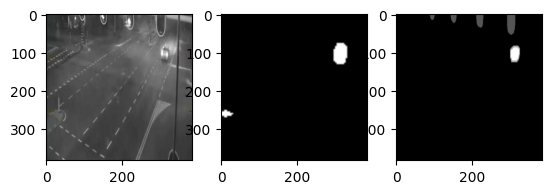

: 

In [58]:
import pylab
pylab.subplot(1, 3, 1)
pylab.imshow(current_frame)
pylab.subplot(1, 3, 2)
pylab.imshow(pred) 
pylab.subplot(1, 3, 3) 
pylab.imshow(gt_frame)

In [37]:
np.abs(long_bg_frame.permute(0,2,3,1)[0].numpy() - current_frame).max()

np.float32(0.10588235)

In [38]:
current_frame.shape, pred.shape, gt_frame.shape

((448, 448, 3), (448, 448, 3), (448, 448, 3))